# 02 — Baseline logP-driven Generator

We use **SELFIES** for robust mutations and **RDKit Crippen logP** as the score.
Objective = `logP − alpha * heavy_atoms + beta * novelty`

- `alpha` discourages runaway chain growth.
- `beta` encourages exploration away from the seeds (Tanimoto-based).

Outputs are written to `../outputs/`.

In [14]:
import os, math, random, json, time
import numpy as np, pandas as pd
from tqdm import trange, tqdm
import selfies as sf

from rdkit import Chem, DataStructs
from rdkit.Chem import Crippen, rdMolDescriptors, AllChem

DATA_DIR = os.path.join("..","data")
OUT_DIR = os.path.join("..","outputs")
os.makedirs(OUT_DIR, exist_ok=True)
SEED = 13
random.seed(SEED); np.random.seed(SEED)

In [8]:
# Utilities
def smiles_to_mol(s):
    try:
        m = Chem.MolFromSmiles(s)
        if m is None: 
            return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def mol_logp(mol):
    try:
        return float(Crippen.MolLogP(mol))
    except Exception:
        return None

def heavy_atoms(mol):
    return int(mol.GetNumHeavyAtoms())

def morgan_fp(mol, radius=2, nbits=1024):
    from rdkit.Chem import rdFingerprintGenerator
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nbits)
    fp = gen.GetFingerprint(mol)
    return fp

def tanimoto(a, b):
    return DataStructs.TanimotoSimilarity(a, b)

def to_selfies(smiles):
    try:
        return sf.encoder(smiles)
    except Exception:
        return None

def to_smiles(selfies_str):
    try:
        return sf.decoder(selfies_str)
    except Exception:
        return None

### Question
What are these functions doing?

How would you recreate them yourselves?

In [9]:
# Build an alphabet for mutations
# SELFIES provides robust alphabets; we can trim to common tokens if desired.
ALPHABET = list(sf.get_semantic_robust_alphabet())
# Optional: ensure some frequent tokens are included
for tok in ["[C]", "[c]", "[O]", "[N]", "[=O]", "[F]", "[Cl]", "[Br]", "[S]"]:
    if tok not in ALPHABET:
        ALPHABET.append(tok)

def tokenize(selfies_str):
    return list(sf.split_selfies(selfies_str))

def random_mutation(selfies_str):
    toks = tokenize(selfies_str)
    if len(toks) == 0:
        toks = ["[C]"]
    op = random.choice(["insert","replace","delete"])
    if op == "delete" and len(toks) > 1:
        idx = random.randrange(len(toks))
        toks.pop(idx)
    elif op == "insert":
        idx = random.randrange(len(toks)+1)
        toks.insert(idx, random.choice(ALPHABET))
    else:  # replace
        idx = random.randrange(len(toks))
        toks[idx] = random.choice(ALPHABET)
    return "".join(toks)

### Question
What is this doing?

How would you extend it?


In [10]:
# Load seeds
seeds = pd.read_csv(os.path.join(DATA_DIR, "seed_smiles.csv"))
seed_smiles = seeds["smiles"].tolist()
seed_mols = [smiles_to_mol(s) for s in seed_smiles]
seed_mols = [m for m in seed_mols if m is not None]
seed_fps = [morgan_fp(m) for m in seed_mols]

len(seed_mols), seed_smiles[:5]

(15,
 ['CCO',
  'c1ccccc1',
  'Cc1ccccc1',
  'CC(=O)OC1=CC=CC=C1C(=O)O',
  'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O'])

### Question
What are seeds?

How would you decide which ones to use?


In [11]:
# Objective
alpha = 0.02  # size penalty per heavy atom
beta = 0.5    # novelty bonus weight

def novelty(mol):
    fp = morgan_fp(mol)
    if fp is None: return 0.0
    sims = [tanimoto(fp, s) for s in seed_fps]
    return 1.0 - max(sims) if sims else 0.0

def objective(mol):
    lp = mol_logp(mol)
    if lp is None: return -1e9
    ha = heavy_atoms(mol)
    nov = novelty(mol)
    return lp - alpha*ha + beta*nov, {"logP": lp, "heavy_atoms": ha, "novelty": nov}

### Question
What is the scoring function balancing?

What happens when you alter these?

Which new ones would you use?


In [12]:
# Beam search with SELFIES mutations
beam_width = 10
neighbors_per_parent = 15
steps = 100

# Initialize beam as SELFIES of seeds
beam = []
for s in seed_smiles[:beam_width]:
    sf_s = to_selfies(s)
    if sf_s: beam.append(sf_s)
if not beam:
    beam = ["[C][C][O]"]

seen = set()
records = []

best = {"score": -1e9, "smiles": None, "meta": {}}

for t in trange(steps, desc="search"):
    proposals = []
    for parent in beam:
        for _ in range(neighbors_per_parent):
            child = random_mutation(parent)
            smi = to_smiles(child)
            if not smi or smi in seen:
                continue
            mol = smiles_to_mol(smi)
            if mol is None:
                continue
            score, meta = objective(mol)
            proposals.append((score, smi, child, meta))
            seen.add(smi)
    if not proposals:
        continue
    proposals.sort(key=lambda x: x[0], reverse=True)
    beam = [p[2] for p in proposals[:beam_width]]  # keep SELFIES strings

    # Log top candidate of this step
    top_score, top_smi, _, meta = proposals[0]
    records.append({"step": t, "smiles": top_smi, "score": top_score, **meta})

    if top_score > best["score"]:
        best = {"score": top_score, "smiles": top_smi, "meta": meta}

df = pd.DataFrame(records)
df.to_csv(os.path.join(OUT_DIR, "baseline_trace.csv"), index=False)

# Save top-50 unique by score
unique = {}
for r in sorted(records, key=lambda x: x["score"], reverse=True):
    smi = r["smiles"]
    if smi not in unique:
        unique[smi] = r
top_df = pd.DataFrame(list(unique.values())).sort_values("score", ascending=False).head(50)
top_df.to_csv(os.path.join(OUT_DIR, "baseline_top50.csv"), index=False)

best["smiles"], best["score"], best["meta"]

search: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.69it/s]


('BrP=[P+1]=[P+1][P+1]P#S[P-1][C-1]C#[P+1][P-1]([P-1])C=[C-1][P+1][P-1][P+1]P=P#[P+1][P-1]P#[P-1][P+1][P-1]=[P+1][P-1]#[P+1][P-1][P-1]=PC=CS#[P+1]C=C[P-1]=PPC=[P-1][C-1]=[P+1]=[P+1]=[C+1][P+1]#P=[P+1]=[P+1]=[P+1]=[P+1][P+1]#[P+1][P-1]=P=P#P=[P+1]=[P+1](C[P+1]=[P-1]#P)S[P-1][P-1]=[P-1]=[P+1]=P#P=[P-1]#[P-1]=[P+1]=[P+1]P[S+1]P[P-1][P+1]=[P+1]=P#S[P-1][N-1][P+1][N-1]SSC[P+1][P-1]P=[P+1]=[S-1][P+1]P=PI',
 68.1047799999999,
 {'logP': 70.1047799999999, 'heavy_atoms': 100, 'novelty': 0.0})

### Question
What is beam search?

What do you think of the output?

How would you alter that / improve it?


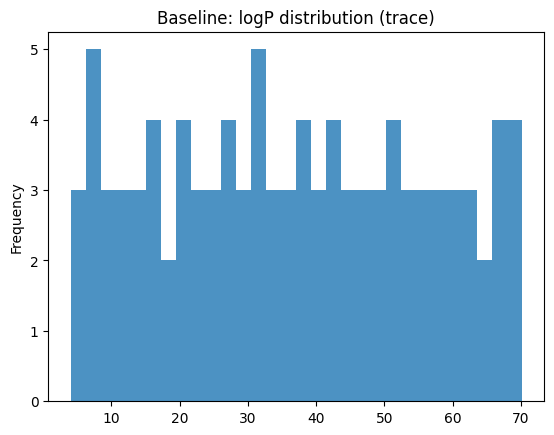

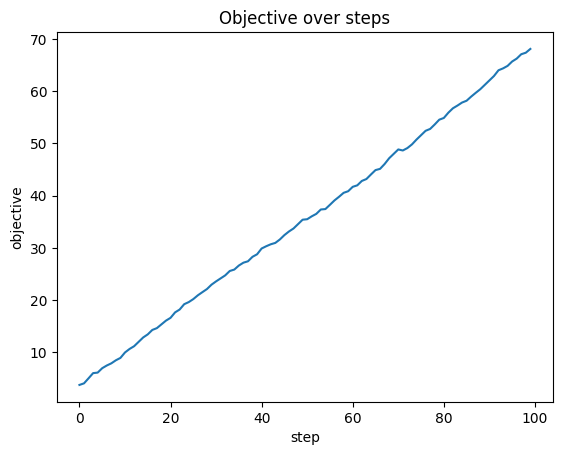

In [13]:
# Plot distributions
import matplotlib.pyplot as plt
trace = pd.read_csv(os.path.join(OUT_DIR, "baseline_trace.csv"))
plt.figure()
trace["logP"].plot(kind="hist", bins=30, alpha=0.8, title="Baseline: logP distribution (trace)")
plt.show()

plt.figure()
trace["score"].plot(kind="line", title="Objective over steps")
plt.xlabel("step"); plt.ylabel("objective")
plt.show()

### Question
Is this an effective optimisation?

What would happen if you carried on going?
